In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

from qga import QGA
from dopnet_loader import DopNetLoader
from preprocessor import Preprocessor
from feature_extractor import FeatureExtractor
from enums import ExtractorMode, GESTURE_NAMES

In [2]:
# Load data
DATA_PATH = "../DATA/raw_mat/Training Data"
loader = DopNetLoader(DATA_PATH)
data = loader.load_normalized(target_shape=(256, 256))

Found 6 .mat files

=== SUMMARY ===
Person: A:
  Gesture 0: 56 samples
  Gesture 1: 98 samples
  Gesture 2: 64 samples
  Gesture 3: 105 samples
Person: B:
  Gesture 0: 112 samples
  Gesture 1: 116 samples
  Gesture 2: 72 samples
  Gesture 3: 105 samples
Person: C:
  Gesture 0: 85 samples
  Gesture 1: 132 samples
  Gesture 2: 80 samples
  Gesture 3: 137 samples
Person: D:
  Gesture 0: 70 samples
  Gesture 1: 112 samples
  Gesture 2: 71 samples
  Gesture 3: 93 samples
Person: E:
  Gesture 0: 56 samples
  Gesture 1: 98 samples
  Gesture 2: 91 samples
  Gesture 3: 144 samples
Person: F:
  Gesture 0: 87 samples
  Gesture 1: 140 samples
  Gesture 2: 101 samples
  Gesture 3: 208 samples


In [3]:
# Data structure check
GESTURE_NAMES = ['Wave', 'Pinch', 'Swipe', 'Click']
person = list(data.keys())[0]

gestures = data[person]

print(f'Person: {person}')
print(f'Gesture count: {len(gestures)}')
for i in range(4):
    print(f'Number of repetitions for a gesture "{GESTURE_NAMES[i]}": {len(gestures[i])}')

example = gestures[0][0]
print('Shape of example spectrogram:', example.shape)


Person: A
Gesture count: 4
Number of repetitions for a gesture "Wave": 56
Number of repetitions for a gesture "Pinch": 98
Number of repetitions for a gesture "Swipe": 64
Number of repetitions for a gesture "Click": 105
Shape of example spectrogram: (256, 256)


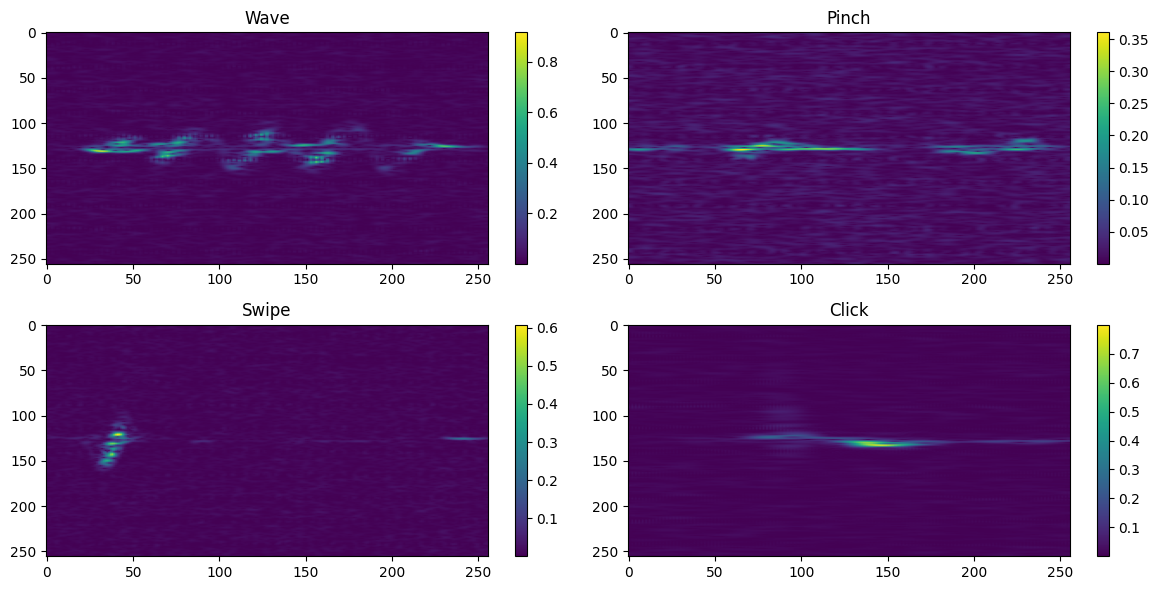

In [19]:
from numpy.fft import fftshift
# Spectrogram visualization
plt.figure(figsize=(12,6))

for i in range(4):
    spec = np.abs(gestures[i][42])
    plt.subplot(2, 2, i+1)
    plt.imshow(spec, aspect="auto", cmap="viridis")
    plt.title(f"{GESTURE_NAMES[i]}")
    plt.colorbar()

plt.tight_layout()
plt.show()


In [13]:
# Features extraction
extractor = FeatureExtractor(mode=ExtractorMode.Magnitude)
X, y = extractor.transform(data)

=== FeatureExtractor ===
Mode: ExtractorMode.Magnitude
  Processing person: A
    Gesture: Wave, repetitions: 56
    Gesture: Pinch, repetitions: 98
    Gesture: Swipe, repetitions: 64
    Gesture: Click, repetitions: 105
  Processing person: B
    Gesture: Wave, repetitions: 112
    Gesture: Pinch, repetitions: 116
    Gesture: Swipe, repetitions: 72
    Gesture: Click, repetitions: 105
  Processing person: C
    Gesture: Wave, repetitions: 85
    Gesture: Pinch, repetitions: 132
    Gesture: Swipe, repetitions: 80
    Gesture: Click, repetitions: 137
  Processing person: D
    Gesture: Wave, repetitions: 70
    Gesture: Pinch, repetitions: 112
    Gesture: Swipe, repetitions: 71
    Gesture: Click, repetitions: 93
  Processing person: E
    Gesture: Wave, repetitions: 56
    Gesture: Pinch, repetitions: 98
    Gesture: Swipe, repetitions: 91
    Gesture: Click, repetitions: 144
  Processing person: F
    Gesture: Wave, repetitions: 87
    Gesture: Pinch, repetitions: 140
    Gesture:

In [20]:
# Preprocessing
preprocessor = Preprocessor(n_components=111)
X_pca = preprocessor.fit_transform(X)

=== Preprocessor.fit_transform ===
Input X shape: (2433, 65536)
Scaling done.
PCA done. Shape after PCA: (2433, 111)


Accuracy: 0.9293924466338259

Classification Report:
               precision    recall  f1-score   support

       Click       0.95      0.92      0.94       198
       Pinch       0.91      0.95      0.93       174
       Swipe       0.93      0.94      0.93       120
        Wave       0.93      0.91      0.92       117

    accuracy                           0.93       609
   macro avg       0.93      0.93      0.93       609
weighted avg       0.93      0.93      0.93       609



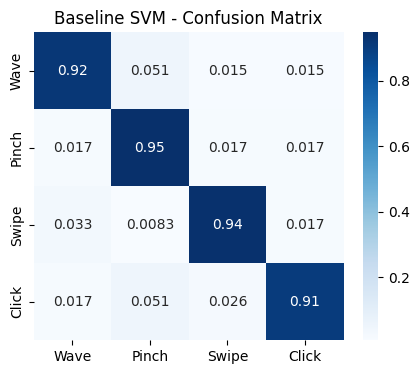

Cross-validation accuracy: 0.9292653921421046


In [21]:
# Baseline SVM (default hyperparameters)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.25, random_state=42, stratify=y
)
labels = GESTURE_NAMES

baseline = SVC(kernel="rbf")
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='Blues',
           xticklabels=labels,
           yticklabels=labels)
plt.title('Baseline SVM - Confusion Matrix')
plt.show()

baseline_cv = cross_val_score(baseline, X_train, y_train, cv=5).mean()
print('Cross-validation accuracy:', baseline_cv)

In [23]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'gamma': [0.00008,0.0001, 0.0003, 0.0005, 0.001, 0.01, 0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\n=== Best Grid Search Parameters ===")
print(grid.best_params_)
print(f"Best CV score: {grid.best_score_:.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits

=== Best Grid Search Parameters ===
{'C': 100, 'gamma': 8e-05}
Best CV score: 0.9677


=== MLP Stratified 5-Fold Cross-Validation ===
Fold scores: [0.9466 0.9343 0.9405 0.9691 0.9259]
Mean accuracy: 0.9433
Std accuracy:  0.0146

=== Hold-Out Test Results ===
Accuracy: 0.9441707717569786

Classification Report:
               precision    recall  f1-score   support

       Click       0.97      0.93      0.95       198
       Pinch       0.90      0.96      0.93       174
       Swipe       0.96      0.94      0.95       120
        Wave       0.96      0.95      0.95       117

    accuracy                           0.94       609
   macro avg       0.95      0.94      0.95       609
weighted avg       0.95      0.94      0.94       609



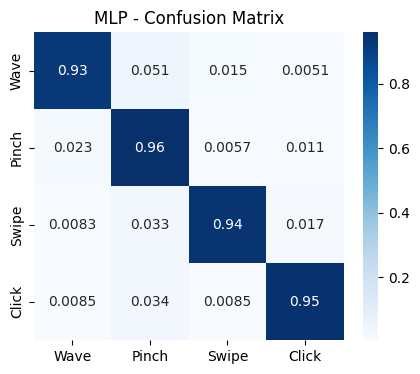

In [24]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=64,
    learning_rate_init=1e-3,
    max_iter=300,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X_pca, y_enc, cv=cv)

print("=== MLP Stratified 5-Fold Cross-Validation ===")
print("Fold scores:", np.round(cv_scores, 4))
print("Mean accuracy:", np.round(cv_scores.mean(), 4))
print("Std accuracy: ", np.round(cv_scores.std(), 4))

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("\n=== Hold-Out Test Results ===")
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')
labels = GESTURE_NAMES

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='Blues',
           xticklabels=labels,
           yticklabels=labels)
plt.title('MLP - Confusion Matrix')
plt.show()



In [25]:
print('=== RUNNING QGA ===')
qga = QGA(
    X_train,
    y_train,
    population_size=15,
    genome_length=24,
    generations=30,
    verbose_logging=True,
    pop_mutation_rate= 0.1,
    mutation_rate= 0.03,
    min_C = -1,
    max_C = 4,
    min_gamma = -5,
    max_gamma = 1,
)
qga.run()

best_gen = qga.history[-1]
print('\nLast generation:', best_gen)

=== RUNNING QGA ===
QUANTUM GENETIC ALGORITHM

[Gen 0] Chromosome 1: C=0.25503, gamma=0.01256, fitness=33.44
[Gen 0] Chromosome 2: C=1231.27225, gamma=0.00001, fitness=93.75
[Gen 0] Chromosome 3: C=6467.62470, gamma=0.00502, fitness=44.90
[Gen 0] Chromosome 4: C=0.13817, gamma=0.00009, fitness=85.31
[Gen 0] Chromosome 5: C=0.50359, gamma=5.92780, fitness=36.84
[Gen 0] Chromosome 6: C=4.01028, gamma=3.17564, fitness=39.91
[Gen 0] Chromosome 7: C=4.70730, gamma=0.66820, fitness=39.91
[Gen 0] Chromosome 8: C=437.54794, gamma=0.00242, fitness=51.59
[Gen 0] Chromosome 9: C=5035.88382, gamma=0.00008, fitness=96.66
[Gen 0] Chromosome 10: C=607.97089, gamma=0.02090, fitness=39.91
[Gen 0] Chromosome 11: C=566.70593, gamma=0.62671, fitness=39.91
[Gen 0] Chromosome 12: C=0.11672, gamma=0.00060, fitness=45.61
[Gen 0] Chromosome 13: C=2.67516, gamma=0.00003, fitness=95.94
[Gen 0] Chromosome 14: C=2285.46386, gamma=0.00887, fitness=41.45
[Gen 0] Chromosome 15: C=876.21956, gamma=0.00010, fitness=96.

In [27]:
best_idx = best_gen['best_index']

effective_bits = qga.genome_length - 1
half = effective_bits // 2
C_bits = qga.chromosome[best_idx, 1:1+half]
gamma_bits = qga.chromosome[best_idx, 1+half:1+effective_bits]

best_C = qga.decode_param(C_bits, -1, 4)
best_gamma = qga.decode_param(gamma_bits, -5, 1)
print("Best C:", best_C)
print("Best gamma:", best_gamma)

Best C: 7786.295672075951
Best gamma: 7.647447135436828e-05


Accuracy: 0.9638752052545156

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       198
           1       0.97      0.95      0.96       174
           2       0.98      0.96      0.97       120
           3       0.92      0.98      0.95       117

    accuracy                           0.96       609
   macro avg       0.96      0.96      0.96       609
weighted avg       0.96      0.96      0.96       609



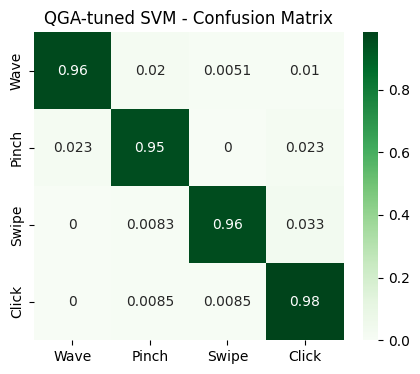

Cross-validation accuracy: 0.9671037181996086


In [32]:
# SVM trained with QGA parameters

svm_qga = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svm_qga.fit(X_train, y_train)

y_pred_qga = svm_qga.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_qga))
print("\nClassification Report:\n", classification_report(y_test, y_pred_qga))

cm_qga = confusion_matrix(y_test, y_pred_qga, normalize='true')
plt.figure(figsize=(5,4))
sns.heatmap(cm_qga, annot=True, cmap='Greens', 
            xticklabels=labels,
            yticklabels=labels)
plt.title('QGA-tuned SVM - Confusion Matrix')
plt.show()

cv_qga = cross_val_score(svm_qga, X_train, y_train, cv=5).mean()
print("Cross-validation accuracy:", cv_qga)